In [7]:
!pip install pathway bokeh --quiet

In [10]:
!pip install pathway --quiet

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import pathway as pw
import bokeh.plotting
import panel as pn

In [5]:
df = pd.read_csv("dataset.csv")
df["Timestamp"] = pd.to_datetime(df["LastUpdatedDate"] + " " + df["LastUpdatedTime"], dayfirst=True)
df = df.sort_values("Timestamp").reset_index(drop=True)
df["OccupancyRate"] = df["Occupancy"] / df["Capacity"]

In [13]:
# Preprocess datetime
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], dayfirst=True)
df = df.sort_values('Timestamp').reset_index(drop=True)

alpha = 5
base_price = 10
min_price = 5
max_price = 20


df['OccupancyRate'] = df['Occupancy'] / df['Capacity']

prices = [base_price]

for i in range(1, len(df)):
    prev_price = prices[-1]
    occ_rate = df.loc[i, 'OccupancyRate']
    new_price = prev_price + alpha * occ_rate
    new_price = np.clip(new_price, min_price, max_price)
    prices.append(new_price)

df['BaselinePrice'] = prices

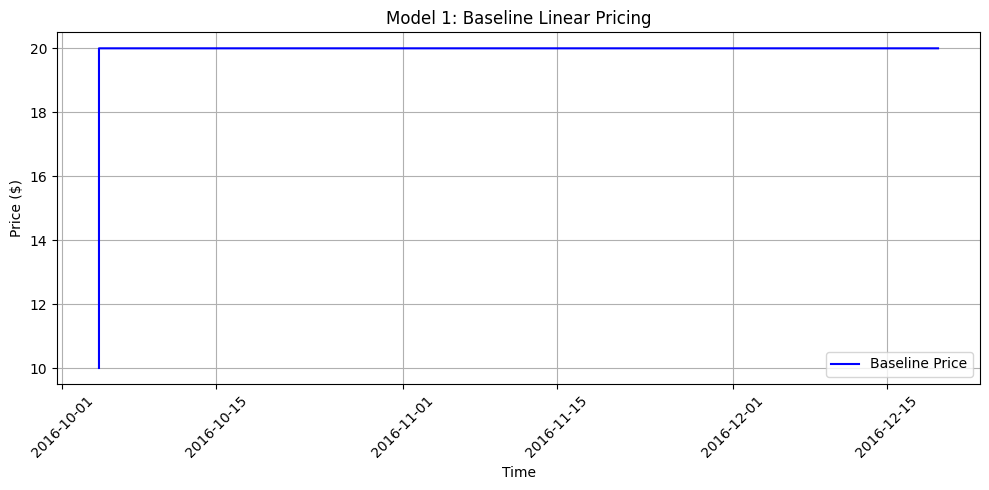

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(df['Timestamp'], df['BaselinePrice'], label='Baseline Price', color='blue')
plt.title("Model 1: Baseline Linear Pricing")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:

vehicle_weights = {
    'bike': 0.5,
    'car': 1.0,
    'truck': 1.5,
    'cycle': 0.3
}

traffic_weights = {
    'low': 1,
    'average': 2,
    'high': 3
}

In [16]:
df['VehicleWeight'] = df['VehicleType'].map(vehicle_weights)
df['TrafficLevel'] = df['TrafficConditionNearby'].map(traffic_weights)

df['VehicleWeight'] = df['VehicleWeight'].fillna(1.0)
df['TrafficLevel'] = df['TrafficLevel'].fillna(2)

In [18]:
α = 3
β = 1.5
γ = 2
δ = 5
ε = 1
λ = 0.8
base_price = 10

df['DemandRaw'] = (
    α * df['OccupancyRate'] +
    β * df['QueueLength'] -
    γ * df['TrafficLevel'] +
    δ * df['IsSpecialDay'] +
    ε * df['VehicleWeight'])

In [19]:
demand_min = df['DemandRaw'].min()
demand_max = df['DemandRaw'].max()
df['DemandNormalized'] = (df['DemandRaw'] - demand_min) / (demand_max - demand_min)

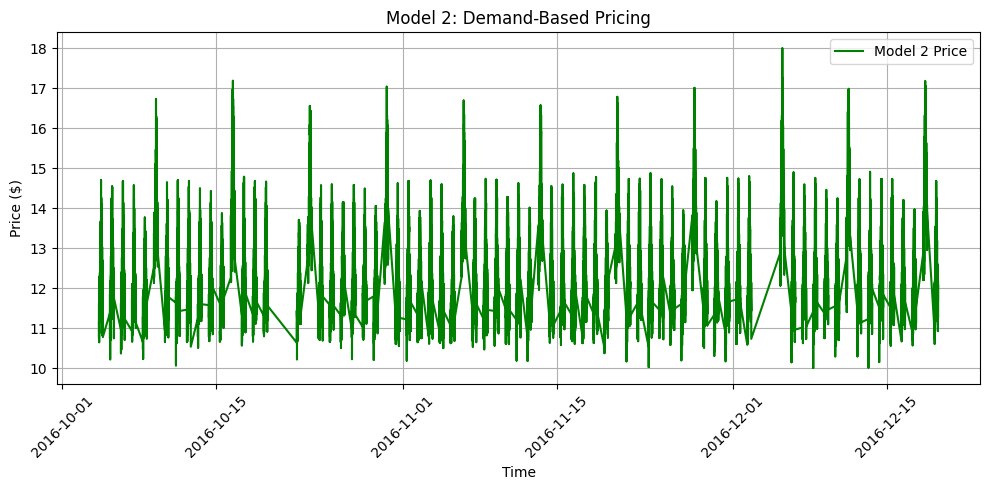

In [20]:
df['Model2Price'] = base_price * (1 + λ * df['DemandNormalized'])
df['Model2Price'] = df['Model2Price'].clip(lower=base_price * 0.5, upper=base_price * 2)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df['Timestamp'], df['Model2Price'], label='Model 2 Price', color='green')
plt.title("Model 2: Demand-Based Pricing")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    d_lat = radians(lat2 - lat1)
    d_lon = radians(lon2 - lon1)
    a = sin(d_lat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(d_lon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

In [22]:
# Get unique parking lots
lots = df[['SystemCodeNumber', 'Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)

# Build a distance matrix
from itertools import product

distances = []
for i, lot1 in lots.iterrows():
    for j, lot2 in lots.iterrows():
        if lot1['SystemCodeNumber'] != lot2['SystemCodeNumber']:
            dist = haversine(lot1['Latitude'], lot1['Longitude'], lot2['Latitude'], lot2['Longitude'])
            distances.append({
                'Lot1': lot1['SystemCodeNumber'],
                'Lot2': lot2['SystemCodeNumber'],
                'DistanceKm': dist
            })

dist_df = pd.DataFrame(distances)

In [23]:
def adjust_price_with_competition(row, model2_price, competitors):
    nearby = competitors[(competitors['Lot1'] == row['SystemCodeNumber']) & (competitors['DistanceKm'] < 1.0)]
    if nearby.empty:
        return model2_price  # No nearby competitors

    # Get average competitor price
    comp_lots = nearby['Lot2'].unique()
    comp_prices = df[(df['SystemCodeNumber'].isin(comp_lots)) & (df['Timestamp'] == row['Timestamp'])]['Model2Price']

    if comp_prices.empty:
        return model2_price

    avg_comp_price = comp_prices.mean()

    # If you're full and competitors are cheaper
    if row['OccupancyRate'] >= 0.95 and model2_price > avg_comp_price:
        return model2_price * 0.95  # Reduce slightly

    # If competitors are expensive
    elif model2_price < avg_comp_price:
        return model2_price * 1.05  # You can charge more

    return model2_price

In [24]:
df['Model3Price'] = df.apply(lambda row: adjust_price_with_competition(row, row['Model2Price'], dist_df), axis=1)


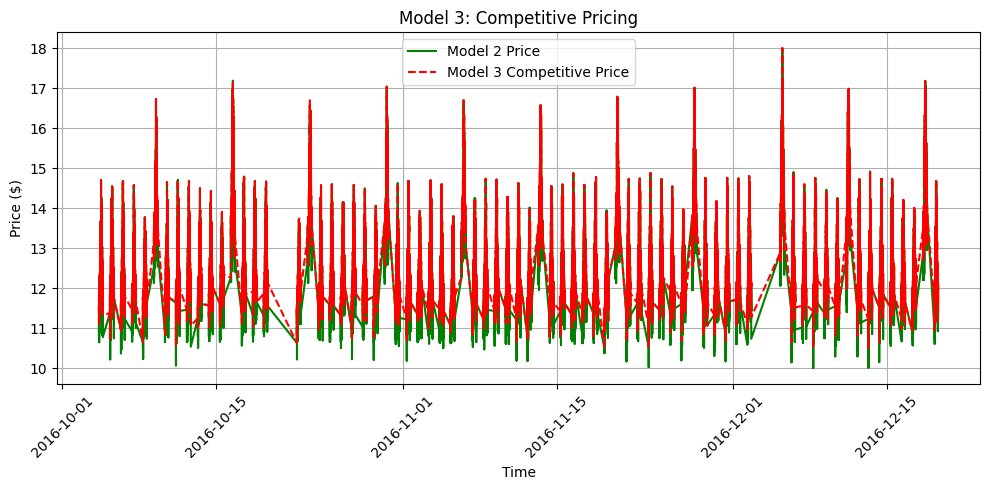

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(df['Timestamp'], df['Model2Price'], label='Model 2 Price', color='green')
plt.plot(df['Timestamp'], df['Model3Price'], label='Model 3 Competitive Price', color='red', linestyle='--')
plt.title("Model 3: Competitive Pricing")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
df["RowId"] = df.index.astype(str)
df[["RowId", "SystemCodeNumber", "Capacity", "Occupancy", "VehicleType",
    "QueueLength", "TrafficConditionNearby", "IsSpecialDay", "Timestamp"]
  ].to_csv("stream_data.csv", index=False)

In [28]:
output_notebook()
from bokeh.models import ColumnDataSource
source = ColumnDataSource(df)

p = figure(x_axis_type="datetime", title="Dynamic Parking Price")
p.line(x='Timestamp', y='Model2Price', source=source, color='green', legend_label='Model 2')
p.line(x='Timestamp', y='BaselinePrice', source=source, color='blue', legend_label='Baseline')
p.legend.location = "top_left"
show(p)